In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
try:
	os.chdir('C:\\Users\\Administrator\\Desktop\\ml_ipynb\\ex5')
	print(os.getcwd())
except:
    print(os.getcwd()+" not changed!!!")



C:\Users\Administrator\Desktop\ml_ipynb\ex5


 # ex5 绘制学习曲线,判断高方差/偏差问题

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
import scipy.optimize as opt
import sys
sys.path.append('..')
sys.path
from helper import formulas





 ## 1 加载数据

In [3]:
data = loadmat('ex5data1.mat')
#看看里面有什么数据,X数据是1维的
#有3组数据,分别是
# 12个训练集X,y
# 21个验证集Xval,yval
# 21个测试集Xtest,ttest
print(data)
# 把3个集合提取出来
X = data['X']
y = data['y'].ravel()
Xcv = data['Xval']
ycv = data['yval'].ravel()
Xtest = data['Xtest']
ytest = data['ytest'].ravel()

print(X.shape)
print(Xcv.shape)
print(Xtest.shape)



{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov  4 22:27:26 2011', '__version__': '1.0', '__globals__': [], 'X': array([[-15.93675813],
       [-29.15297922],
       [ 36.18954863],
       [ 37.49218733],
       [-48.05882945],
       [ -8.94145794],
       [ 15.30779289],
       [-34.70626581],
       [  1.38915437],
       [-44.38375985],
       [  7.01350208],
       [ 22.76274892]]), 'y': array([[ 2.13431051],
       [ 1.17325668],
       [34.35910918],
       [36.83795516],
       [ 2.80896507],
       [ 2.12107248],
       [14.71026831],
       [ 2.61418439],
       [ 3.74017167],
       [ 3.73169131],
       [ 7.62765885],
       [22.7524283 ]]), 'Xtest': array([[-33.31800399],
       [-37.91216403],
       [-51.20693795],
       [ -6.13259585],
       [ 21.26118327],
       [-40.31952949],
       [-14.54153167],
       [ 32.55976024],
       [ 13.39343255],
       [ 44.20988595],
       [ -1.14267768],
       [-12.76686065],
       [ 34.05450539],
 

 把训练集数据画出来

No handles with labels found to put in legend.


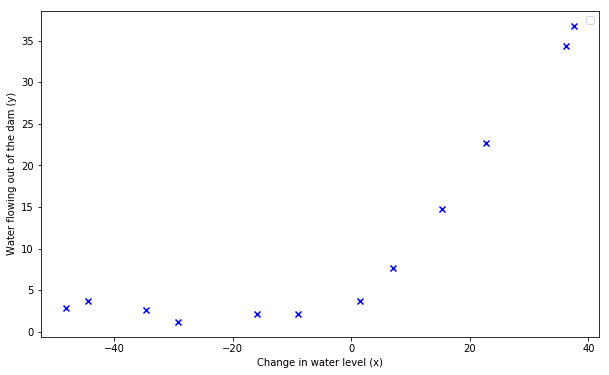

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X,y, c='b', marker='x')
ax.legend()
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
plt.show()



 ## 2 开始用一次函数去拟合这些数据,模拟高偏差的情况
 首先测试一下正则化代价函数,梯度

In [5]:
# 因为X的数据是一维的,所以只有theta2个参数就可以了
[m,n] = X.shape
[m_cv,n_cv] = Xcv.shape
[m_test,n_test] = Xcv.shape
X_t = np.insert(X, 0, values=np.ones(m), axis=1)
lmd = 1
theta_t = np.ones(2)
J = formulas.linearReg_cost_reg(theta_t,X_t,y,lmd)
print("With lmd = 1,Cost is {},this value should be  303.993192".format(J))

grad = formulas.linearReg_grad_reg(theta_t,X_t,y,lmd)
print("With lmd = 1,grad is {},this value should be  [-15.303016; 598.250744]".format(grad))



With lmd = 1,Cost is 303.9931922202643,this value should be  303.993192
With lmd = 1,grad is [-15.30301567 598.25074417],this value should be  [-15.303016; 598.250744]


In [6]:
# 定义训练函数


In [6]:
def trainLinearReg(X,y,lmd):
    [m,n] = X.shape
    init_theta = np.zeros(n+1)
    X_t = np.insert(X, 0, values=np.ones(m), axis=1)
    result = opt.fmin_cg(f=formulas.linearReg_cost_reg,
            x0=init_theta, fprime=formulas.linearReg_grad_reg, 
            maxiter=200,disp=True,full_output=True,args=(X_t, y,lmd))
    opt_theta = result[0]
    return opt_theta



In [7]:
# ok上面的没有问题,开始真正运行
opt_theta = trainLinearReg(X,y,lmd)




Optimization terminated successfully.
         Current function value: 22.379542
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


 画出拟合的函数

No handles with labels found to put in legend.


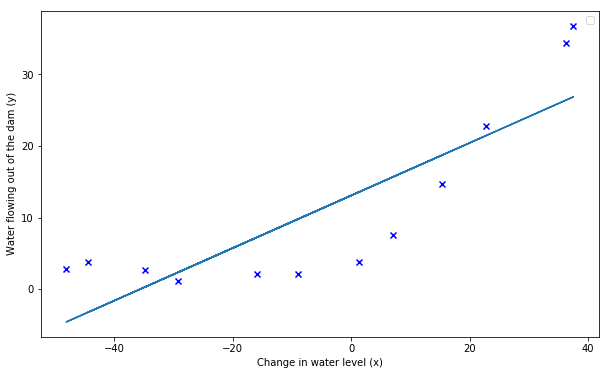

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X,y, c='b', marker='x')
ax.legend()
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
ax.plot(X,X_t @ opt_theta)
plt.show()



 现在我们画出训练集和验证集的learning curve
 先定义学习曲线函数

In [9]:
def learningCurve(X,y,Xval,yval,lmd):
    # 多少个样本
    m = X.shape[0]
    error_train = np.zeros(m)
    error_cv = np.zeros(m)
    # 开始循环
    for i in range(m):
        #每次只要前i个数据
        X_t = X[0:i+1,:]
        y_t = y[0:i+1]
        theta = trainLinearReg(X_t,y_t,lmd)
        # 训练出本次的最佳参数了,计算这个参数
        # 分别在验证集和训练集上面的误差
        # 注意lmd是0

        # 这里插入一行,才能计算
        X_t = np.insert(X_t, 0, values=np.ones(i+1), axis=1)
        err_tr = formulas.linearReg_cost_reg(theta,X_t,y_t,0)
        # 对于验证集,必须每次都计算全部的验证集的误差
        Xval_t =  np.insert(Xval, 0, values=np.ones(m_cv), axis=1)
        err_cv = formulas.linearReg_cost_reg(theta,Xval_t,yval,0)
        error_train[i] = err_tr
        error_cv[i] = err_cv

    return error_train,error_cv







Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 3.286595
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 2.842678
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.154049
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 19.443963
         Iterations: 22
         Function evaluations: 34
        

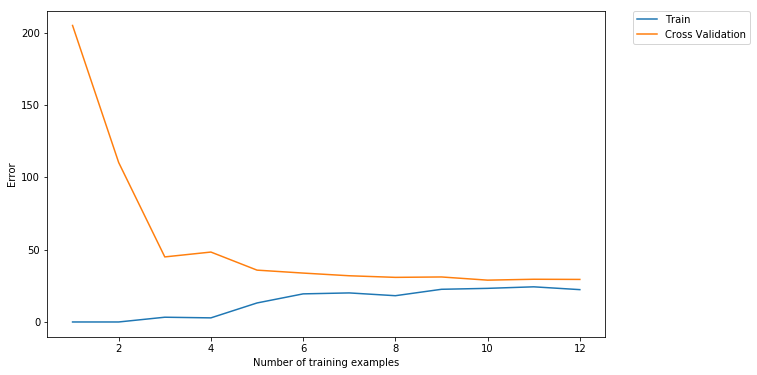

In [10]:
lmd = 0
error_train,error_cv = learningCurve(X,y,Xcv,ycv,lmd)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(m)+1,error_train,label="Train")
ax.plot(np.arange(m)+1,error_cv,label="Cross Validation")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')
plt.show()





 ## 3 处理高方差问题
 可以看到,训练误差和cv误差都是比较高的,这是一个高方差的问题
 我们可以通过提高次数形成多项式来解决这个问题
 首先我们定义这个函数
 因为多项式,所以必须特征归一化处理

In [11]:

# return  X_poly(i, :) = [X(i) X(i).^2 X(i).^3 ...  X(i).^p];
def polyFeatures(X,p):
    [m,n] = X.shape
    # 首先初始化为0,有多少次方就有多少列
    X_poly = np.zeros((m,p))
    for i in range(p):
        # 把第i列置为第i次方
        X_poly[:,i] = X[:,0]**(i+1)
    return X_poly

# 特征归一化函数
def featuresNormalize(X,mu=None,std=None):
    [m,n] = X.shape
    X_norm = np.zeros((m,n))
    # 每一列都是单独的次方,所以归一是对列进行操作的
    if mu is None:
        mu = np.mean(X,axis = 0)
    # 要对每一列进行特征归一,用for循环每一列把,不知道有没有别的方法
    for i in range(n):
        X_norm[:,i] = X[:,i] - mu[i]
    #注意,先计算mu,然后计算std
    if std is None:
        std = np.std(X_norm,axis = 0)
    for i in range(n):
        X_norm[:,i] = X_norm[:,i]/std[i]
    return X_norm,mu,std



 然后我们开始运行多项式的版本

In [12]:
p = 8
X_poly = polyFeatures(X, p)
[X_norm,mu,std] = featuresNormalize(X_poly)
#X_norm = np.insert(X_norm, 0, values=np.ones(m), axis=1)#add ones 

# 测试集也要,使用训练集的mu和std
X_poly_test = polyFeatures(Xtest, p)
Xtest_norm = featuresNormalize(X_poly_test,mu,std)[0]
#Xtest_norm = np.insert(Xtest_norm, 0, values=np.ones(m_test), axis=1)#add ones 

# 然后是验证集
X_poly_cv = polyFeatures(Xcv, p)
Xcv_norm = featuresNormalize(X_poly_cv,mu,std)[0]
#Xcv_norm = np.insert(Xcv_norm, 0, values=np.ones(m_cv), axis=1)#add ones 



 数据处理好了,开始运行

         Current function value: 0.071643
         Iterations: 200
         Function evaluations: 368
         Gradient evaluations: 368


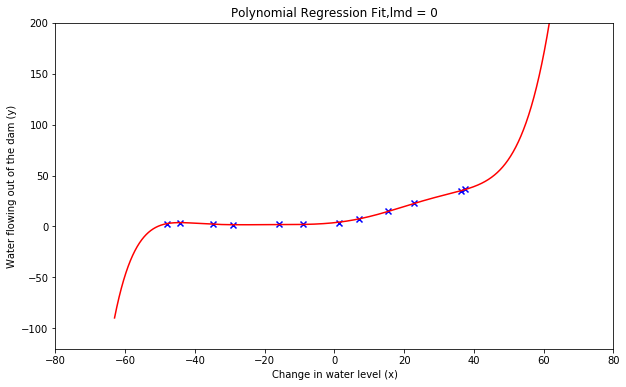

In [13]:
# 可以更改这个值,看看不同的效果
lmd= 0
# 使用多项式训练出参数
opt_theta = trainLinearReg(X_norm,y,lmd)
# 画出图片
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(X,y, c='b', marker='x')
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
# 开始画拟合曲线
# 确定画图的区间
x_start = np.min(X)
x_end = np.max(X)
x_interval = np.arange(x_start-15,x_end+25,0.05)
# 把区间上的所有值都映射成多项式特征
x_inter_matrix = x_interval.reshape((x_interval.size,1))
x_inter_matrix = polyFeatures(x_inter_matrix,p)
# 注意,必须使用前面算出来的mu和std
x_inter_matrix,*unused = featuresNormalize(x_inter_matrix,mu,std)
# 插入一列1
x_inter_matrix = np.insert(x_inter_matrix, 0, values=
    np.ones(x_inter_matrix.shape[0]),
    axis=1)
plt.axis([-80, 80,-120,200])
ax.plot(x_interval,x_inter_matrix @ opt_theta,color='r')
#ax.se_xbound()
plt.title("Polynomial Regression Fit,lmd = 0")

# 怎么跟matlab里面的有点不一样呢?纠结.....
plt.show()



 开始画出learning curve

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 27
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 35
         Gradient evaluations: 35
         Current function value: 0.000030
         Iterations: 200
         Function evaluations: 349
         Gradient evaluations: 349
Optimizati

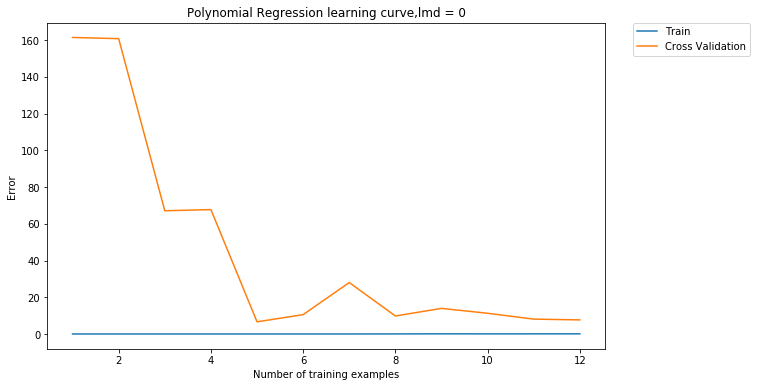

In [14]:
error_train,error_cv = learningCurve(X_norm,y,Xcv_norm,ycv,lmd)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(m)+1,error_train,label="Train")
ax.plot(np.arange(m)+1,error_cv,label="Cross Validation")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')
plt.title("Polynomial Regression learning curve,lmd = 0")
plt.show()



 ## 4 选择lmd
 可以看到,过拟合了,我们需要选择合适的lmd

In [15]:
# Selected values of lambda (you should not change this)
lambda_vec = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
lmd_size = len(lambda_vec)
error_train = np.zeros(lmd_size)
error_cv = np.zeros(lmd_size)
for i in range(lmd_size):
    lmd = lambda_vec[i]
    theta = trainLinearReg(X_norm,y,lmd)
    X_t = np.insert(X_norm, 0, values=np.ones(m), axis=1)
    err_tr = formulas.linearReg_cost_reg(theta,X_t,y,0)
    Xcv_t =  np.insert(Xcv_norm, 0, values=np.ones(m_cv), axis=1)
    err_cv = formulas.linearReg_cost_reg(theta,Xcv_t,ycv,0)
    error_train[i] = err_tr
    error_cv[i] = err_cv



         Current function value: 0.071643
         Iterations: 200
         Function evaluations: 368
         Gradient evaluations: 368
         Current function value: 0.169572
         Iterations: 200
         Function evaluations: 389
         Gradient evaluations: 389
Optimization terminated successfully.
         Current function value: 0.243172
         Iterations: 172
         Function evaluations: 333
         Gradient evaluations: 333
Optimization terminated successfully.
         Current function value: 0.371282
         Iterations: 139
         Function evaluations: 274
         Gradient evaluations: 274
Optimization terminated successfully.
         Current function value: 0.636703
         Iterations: 146
         Function evaluations: 258
         Gradient evaluations: 258
Optimization terminated successfully.
         Current function value: 1.360572
         Iterations: 88
         Function evaluations: 164
         Gradient evaluations: 164
Optimization terminated suc

 画出关于lmd的图

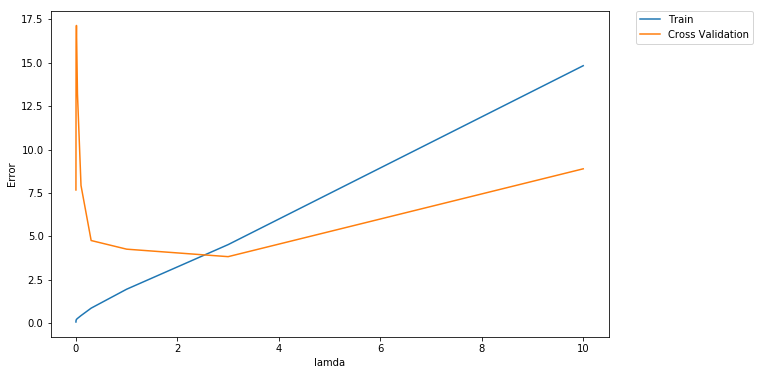

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(lambda_vec,error_train,label="Train")
ax.plot(lambda_vec,error_cv,label="Cross Validation")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('lamda')
ax.set_ylabel('Error')

# 可以看出,2-3之间是最好的lmd
plt.show()



